# Exploration of the PII Detection Dataset

This work builds substantially off of @snassimr's notebook here: https://www.kaggle.com/code/snassimr/pii-data-detection-eda

# Setup 

In [1]:
# SYS_INPUT_DIR = '/kaggle/input/pii-detection-removal-from-educational-data'
SYS_INPUT_DIR = 'competition_data'

In [2]:
import os
import numpy as np
import warnings
import pandas as pd

warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Read training data

In [3]:
import json
train_json = json.load(open(os.path.join(SYS_INPUT_DIR, "train.json")))
df_train = pd.json_normalize(train_json)

In [4]:
df_train.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [5]:
# Check train has one row per document
assert df_train['document'].nunique() == df_train.shape[0]

In [6]:
full_ner_labels = [
    'B-NAME_STUDENT', 'I-NAME_STUDENT',
    'B-URL_PERSONAL', 'I-URL_PERSONAL',
    'B-ID_NUM', 'I-ID_NUM',
    'B-EMAIL', 'I-EMAIL',
    'B-STREET_ADDRESS', 'I-STREET_ADDRESS',
    'B-PHONE_NUM', 'I-PHONE_NUM',
    'B-USERNAME', 'I-USERNAME'
]

# Calculate stats

In [7]:
df_train_eda = df_train.copy()
# Find documents with high number of entities
df_train_eda['ner_labels'] = df_train_eda['labels'].apply(lambda x: [item for item in x if item != 'O'])
df_train_eda['count_ner_labels'] = df_train_eda['ner_labels'].apply(len)
df_train_eda['count_distinct_ner_labels'] = df_train_eda['ner_labels'].apply(lambda x: len(set(x)))
df_train_eda.sort_values(by='count_distinct_ner_labels', inplace=True, ascending=False)

exploded_df = df_train_eda['ner_labels'].explode()
dummies = pd.get_dummies(exploded_df).reset_index()

frequency = dummies.sum().sort_values(ascending=False)
ordered_columns = frequency.index.tolist() ; ordered_columns.remove("index")

counted = dummies.groupby('index').sum()
counted = counted.reindex(columns=full_ner_labels, fill_value=0)
counted = counted[ordered_columns + [i for i in full_ner_labels if i not in ordered_columns]]

df_train_eda = df_train_eda.join(counted)

In [8]:
df_train_eda.head()

,document,full_text,tokens,trailing_whitespace,labels,ner_labels,count_ner_labels,count_distinct_ner_labels,B-NAME_STUDENT,I-NAME_STUDENT,B-URL_PERSONAL,B-ID_NUM,B-EMAIL,I-STREET_ADDRESS,I-PHONE_NUM,B-PHONE_NUM,B-USERNAME,B-STREET_ADDRESS,I-ID_NUM,I-URL_PERSONAL,I-EMAIL,I-USERNAME
1103,9854,Waseem Mabunda 591 Smith Centers Apt. 656\nJo...,"[Waseem, Mabunda, , 591, Smith, Centers, Apt,...","[True, True, False, True, True, True, False, T...","[B-NAME_STUDENT, I-NAME_STUDENT, O, B-STREET_A...","[B-NAME_STUDENT, I-NAME_STUDENT, B-STREET_ADDR...",15,6,1,1,1,0,0,10,0,1,0,1,0,0,0,0
219,4777,"Assignment: Reflection on Design Thinking, Sto...","[Assignment, :, Reflection, on, Design, Thinki...","[False, True, True, True, True, False, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[B-NAME_STUDENT, I-NAME_STUDENT, I-NAME_STUDEN...",8,5,1,2,0,0,1,0,3,1,0,0,0,0,0,0
350,6243,Name: Jana Telfah Email: nbarker@hotmail.com ...,"[Name, :, Jana, Telfah, , Email, :, nbarker@h...","[False, True, True, True, False, False, True, ...","[O, O, B-NAME_STUDENT, I-NAME_STUDENT, O, O, O...","[B-NAME_STUDENT, I-NAME_STUDENT, B-EMAIL, B-PH...",21,5,3,3,0,0,3,0,9,3,0,0,0,0,0,0
24,379,"COURSERA – University of Virginia, Darden Scho...","[COURSERA, –, University, of, Virginia, ,, Dar...","[True, True, True, True, False, True, True, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[B-NAME_STUDENT, I-NAME_STUDENT, B-EMAIL, B-UR...",6,4,2,2,1,0,1,0,0,0,0,0,0,0,0,0
440,7308,Md Carrillo\n\nlisarose@gmail.com\n\ndiazkrist...,"[Md, Carrillo, \n\n, lisarose@gmail.com, \n\n,...","[True, False, False, False, False, False, Fals...","[B-NAME_STUDENT, I-NAME_STUDENT, O, B-EMAIL, O...","[B-NAME_STUDENT, I-NAME_STUDENT, B-EMAIL, B-EM...",10,4,2,2,2,0,4,0,0,0,0,0,0,0,0,0


In [9]:
df_train_eda["count_ner_labels"].sum()

2739

In [10]:
len(df_train_eda)

6807

**Observe:** Across the 6807 essays, there are only 2739 PII tokens in the training set, or less than 1 token per essay!

# Explore most interesting documents

Interesting documents are those with many distinct NER labels

In [11]:
sample_train = df_train_eda.sort_values("count_ner_labels", ascending=False).head(3)

In [12]:
sample_train

,document,full_text,tokens,trailing_whitespace,labels,ner_labels,count_ner_labels,count_distinct_ner_labels,B-NAME_STUDENT,I-NAME_STUDENT,B-URL_PERSONAL,B-ID_NUM,B-EMAIL,I-STREET_ADDRESS,I-PHONE_NUM,B-PHONE_NUM,B-USERNAME,B-STREET_ADDRESS,I-ID_NUM,I-URL_PERSONAL,I-EMAIL,I-USERNAME
1951,11566,"Case Study\n\nMembers:\n\nEmily,Giuseppe,Giuse...","[Case, Study, \n\n, Members, :, \n\n, Emily, ,...","[True, False, False, False, False, False, Fals...","[O, O, O, O, O, O, B-NAME_STUDENT, O, B-NAME_S...","[B-NAME_STUDENT, B-NAME_STUDENT, B-NAME_STUDEN...",34,1,34,0,0,0,0,0,0,0,0,0,0,0,0,0
29,609,Date:14-09-2021\n\nNEWS PAPER\n\nProject: News...,"[Date:14, -, 09, -, 2021, \n\n, NEWS, PAPER, \...","[False, False, False, False, False, False, Tru...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[B-NAME_STUDENT, I-NAME_STUDENT, B-ID_NUM, B-N...",26,3,9,8,0,9,0,0,0,0,0,0,0,0,0,0
289,5606,Project: SPECTACLES\n\nInterviewer Name: Vijay...,"[Project, :, SPECTACLES, \n\n, Interviewer, Na...","[False, True, False, False, True, False, True,...","[O, O, O, O, O, O, O, B-NAME_STUDENT, I-NAME_S...","[B-NAME_STUDENT, I-NAME_STUDENT, B-NAME_STUDEN...",23,3,9,6,0,8,0,0,0,0,0,0,0,0,0,0


## Display functions

In [13]:
from bs4 import BeautifulSoup

ner_colors = {
    'B-NAME_STUDENT': 'rgb(255, 179, 179)',
    'I-NAME_STUDENT': 'rgb(139, 0, 0)',
    'B-URL_PERSONAL': 'rgb(255, 223, 179)',
    'I-URL_PERSONAL': 'rgb(255, 140, 0)',
    'B-ID_NUM': 'rgb((255, 255, 179)',
    'I-ID_NUM':  'rgb(204, 204, 0)',
    'B-EMAIL': 'rgb(179, 255, 179)',
    'I-EMAIL': 'rgb(0, 100, 0)',
    'B-STREET_ADDRESS':  'rgb(179, 223, 255)',
    'I-STREET_ADDRESS': 'rgb(0, 0, 139)',
    'B-PHONE_NUM': 'rgb(223, 179, 255)',
    'I-PHONE_NUM': 'rgb(75, 0, 130)',
    'B-USERNAME': 'rgb(255, 179, 223)',
    'I-USERNAME': 'rgb(231, 84, 128)',
}

def generate_legend():
    legend_html = '<div class="legend" style="margin-bottom: 10px;">'
    for entity, color in ner_colors.items():
        legend_html += f'<span style="color: {color}; margin-right: 10px;">{entity}</span>'
    legend_html += '</div>'
    return legend_html

def highlight_entities(text, tokens, labels):
    legend = generate_legend()  # Generate the legend
    soup = BeautifulSoup(legend, 'html.parser')  # Start with the legend

    last_idx = 0
    for token, label in zip(tokens, labels):
        start, end = text.find(token, last_idx), text.find(token, last_idx) + len(token)

        if start != -1:
            soup.append(BeautifulSoup(text[last_idx:start], 'html.parser'))

            if label != 'O':
                token_span = soup.new_tag('span', style=f'color: {ner_colors.get(label, "black")}; font-family: "Tahoma"; padding: 0 2px; border-radius: 3px;')
                token_span.string = token
                soup.append(token_span)
                
                label_span = soup.new_tag('span', style=f'color: {ner_colors.get(label, "black")}; font-family: Tahoma; font-weight: bold; padding: 0 2px; border-radius: 3px;')
                label_span.string = f" [{label}]"
                soup.append(label_span)
            else:
                soup.append(token)

            last_idx = end

    soup.append(BeautifulSoup(text[last_idx:], 'html.parser'))
    return str(soup).replace('\n', '<br/>')

def label_color(label):
    return ner_colors.get(label, 'black')  # Default color

## Display top interesting documents

In [14]:
sample_train.loc[:, 'html'] = sample_train.apply(lambda x: highlight_entities(x['full_text'], x['tokens'], x['labels']), axis=1)

In [15]:
from IPython.display import display, HTML

for html in sample_train['html']:
    display(HTML(html))

You can adjust coloring in ner_colors dictionary

# NER labels data distribution

## Data

In [16]:
num_documents = df_train_eda.shape[0]
ner_labels_data = df_train_eda[full_ner_labels].melt(var_name='ner_label', value_name='count')
ner_labels_stat = ner_labels_data.groupby('ner_label').agg(
    doc_count=pd.NamedAgg(column='count', aggfunc=lambda x: (x > 0).sum()),
    ner_count=pd.NamedAgg(column='count', aggfunc="sum"),
).reset_index()
ner_labels_stat['doc_count_percentage'] = np.round(ner_labels_stat['doc_count'] /num_documents,4)
ner_labels_stat['ner_count_percentage'] = np.round(ner_labels_stat['ner_count'] /sum(ner_labels_stat['ner_count']),4)

ner_labels_stat = ner_labels_stat.sort_values('doc_count', ascending=False)

In [17]:
ner_labels_stat

,ner_label,doc_count,ner_count,doc_count_percentage,ner_count_percentage
2,B-NAME_STUDENT,891,1365,0.1309,0.4984
9,I-NAME_STUDENT,814,1096,0.1196,0.4001
5,B-URL_PERSONAL,72,110,0.0106,0.0402
1,B-ID_NUM,33,78,0.0048,0.0285
0,B-EMAIL,24,39,0.0035,0.0142
6,B-USERNAME,5,6,0.0007,0.0022
3,B-PHONE_NUM,4,6,0.0006,0.0022
10,I-PHONE_NUM,3,15,0.0004,0.0055
4,B-STREET_ADDRESS,2,2,0.0003,0.0007
11,I-STREET_ADDRESS,2,20,0.0003,0.0073


## Plot function

In [18]:
def plot_ner_distribution(ner_labels_stat, count_col, percentage_col):
    
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    
    plt.figure(figsize=(16,8))
    unique_labels = ner_labels_stat['ner_label'].unique()
    colors = plt.cm.hsv(np.linspace(0, 1, len(unique_labels)))
    color_dict = dict(zip(unique_labels, colors))
    
    for label in unique_labels:
        subset = ner_labels_stat[ner_labels_stat['ner_label'] == label]
        plt.bar(subset['ner_label'], subset[count_col], color=color_dict[label])
        
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Create secondary y-axis for percentage
    sec_axis = plt.twinx()
    sec_axis.plot(ner_labels_stat['ner_label'], ner_labels_stat[percentage_col], color='r')
    sec_axis.set_ylabel('Percentage')
    
    # Titles and labels
    plt.title('Count / Percentage of NER Labels')
    plt.xlabel('NER Label')

## NER labels vs. Number of documents

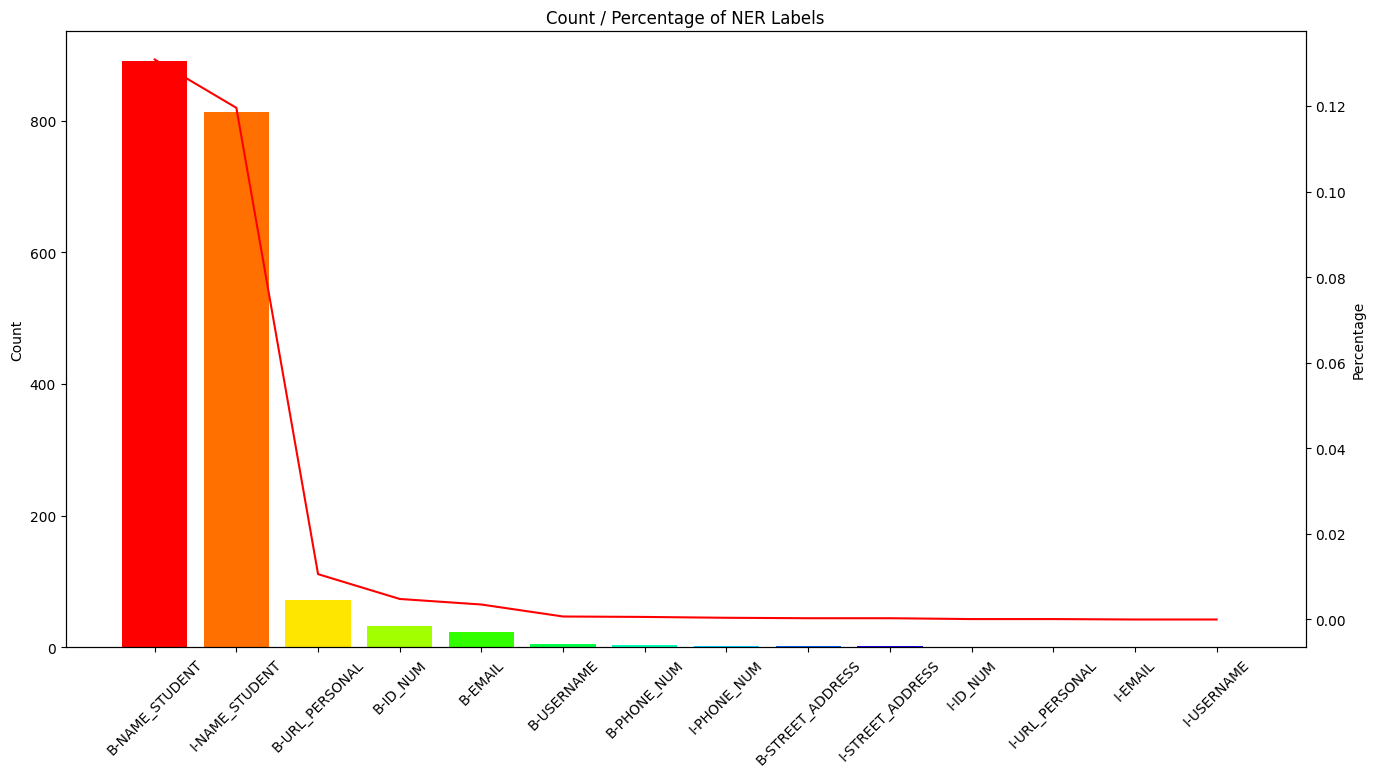

In [19]:
plot_ner_distribution(ner_labels_stat, 'doc_count', 'doc_count_percentage')

## NER labels distributions

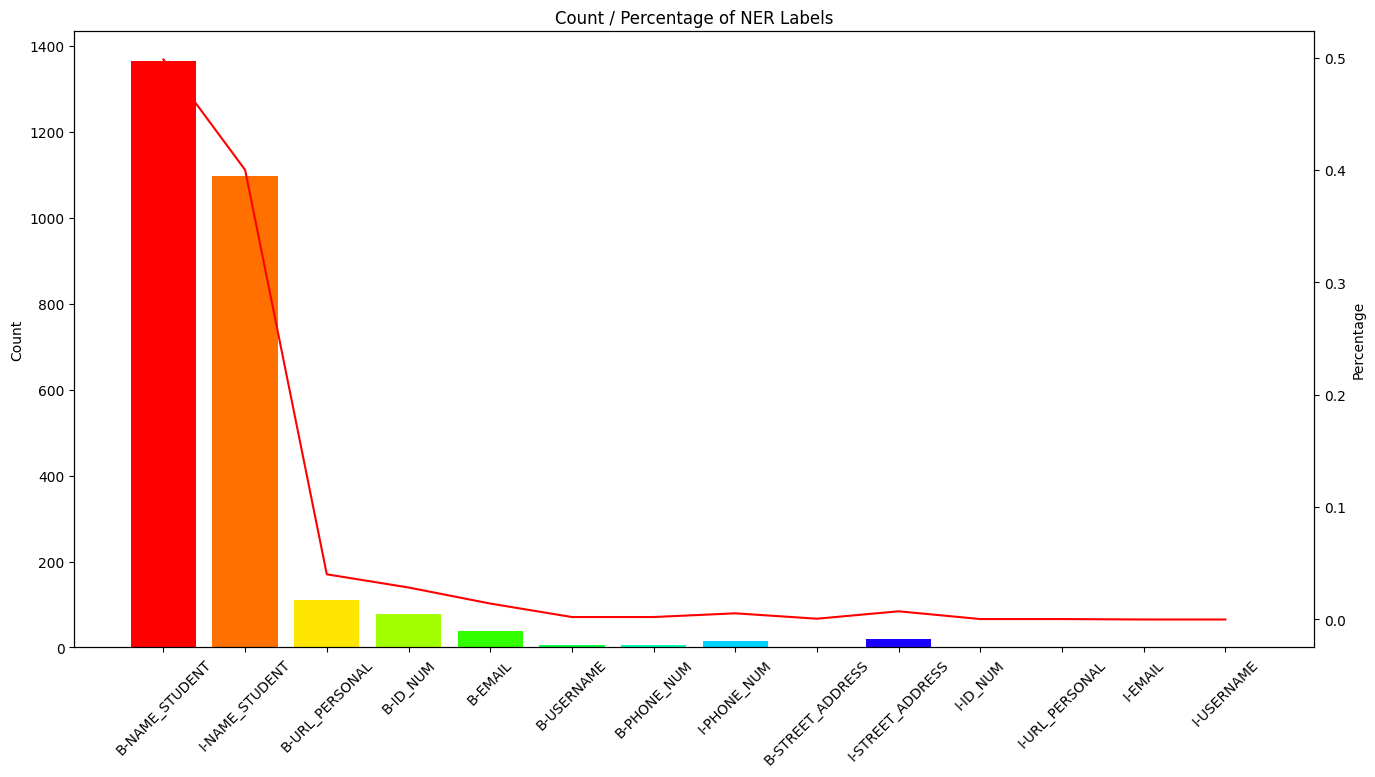

In [20]:
plot_ner_distribution(ner_labels_stat, 'ner_count', 'ner_count_percentage')

Overall, student names account for most of the PII tokens in the dataset and are present in about 12% of the essays in the training set. Personal URLs, ID numbers, and email addresses also represent a significant portion of the PII tokens, which could affect overall accuracy of the model.

# Distribution of PII tokens by location

Let's check out how the PII tokens are distributed within the essays themselves to look for any biases there.

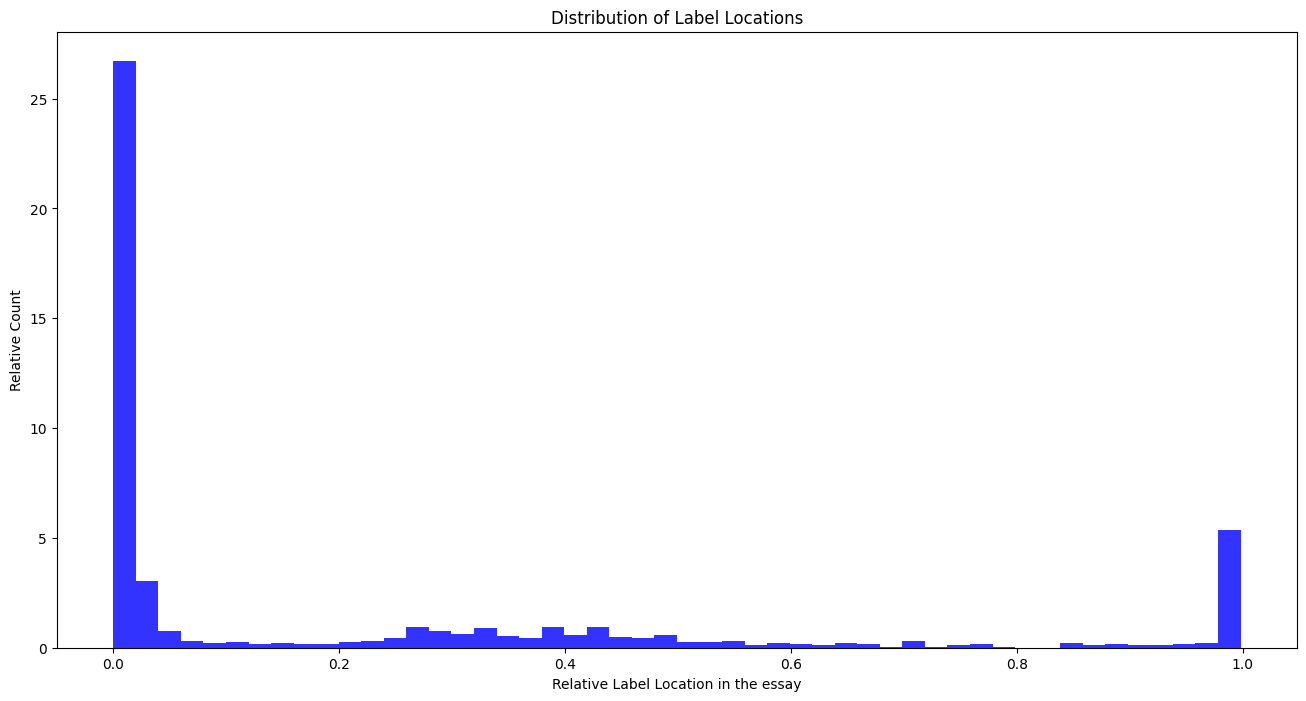

In [21]:
df_pii_token_distro = df_train_eda[["document", "full_text", "tokens", "trailing_whitespace", "labels"]].copy()
df_pii_token_distro["label_location"] = df_pii_token_distro.apply(lambda x: [i / len(x["labels"]) for i, label in enumerate(x["labels"]) if label != "O"], axis=1)
agg_label_location = df_pii_token_distro[["document", "label_location"]].explode("label_location").dropna().groupby("document").agg("mean").reset_index()

# Make a histogram of the label locations
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.hist(agg_label_location["label_location"], bins=50, alpha=0.8, density=True, color='b')
plt.title("Distribution of Label Locations")
plt.xlabel("Relative Label Location in the essay")
plt.ylabel("Relative Count")
plt.show()


**Observe:** There's a clear bias in the distribution of PII tokens in the essays towards the start and end of the documents. (About 70% by eyeballing the density plot setting.) This confirms a suspicion I had that most of the PII was in a title page or author information at the end of a structured document. This also suggests that searching for PII in both directions should yield better results in case the PII is repeated in the middle of the document. In short, bi-directional models like BERT should be more effective than unidirectional ones.

We also see some cases displayed in the data above where the PII tokens are in the middle of the document. One example document looks like a story involving the students and the other looks like a student conducting a series of interviews with other students. It would be interesting to see if there are batches of similar documents in the dataset that could help the PII detector learn to recognize these patterns.

# Document segmentation

Let's see how many documents have PII tokens only near the beginning or end of the document.

In [22]:
def classify_doc(x):
    if len(x["label_location"]) == 0:
        return 0
    elif np.amax(x["label_location"]) < 0.1:
        return 1
    elif np.amin(x["label_location"]) > 0.9:
        return 2
    else:
        return 3

df_pii_token_distro["document_class"] = df_pii_token_distro.apply(classify_doc, axis=1)

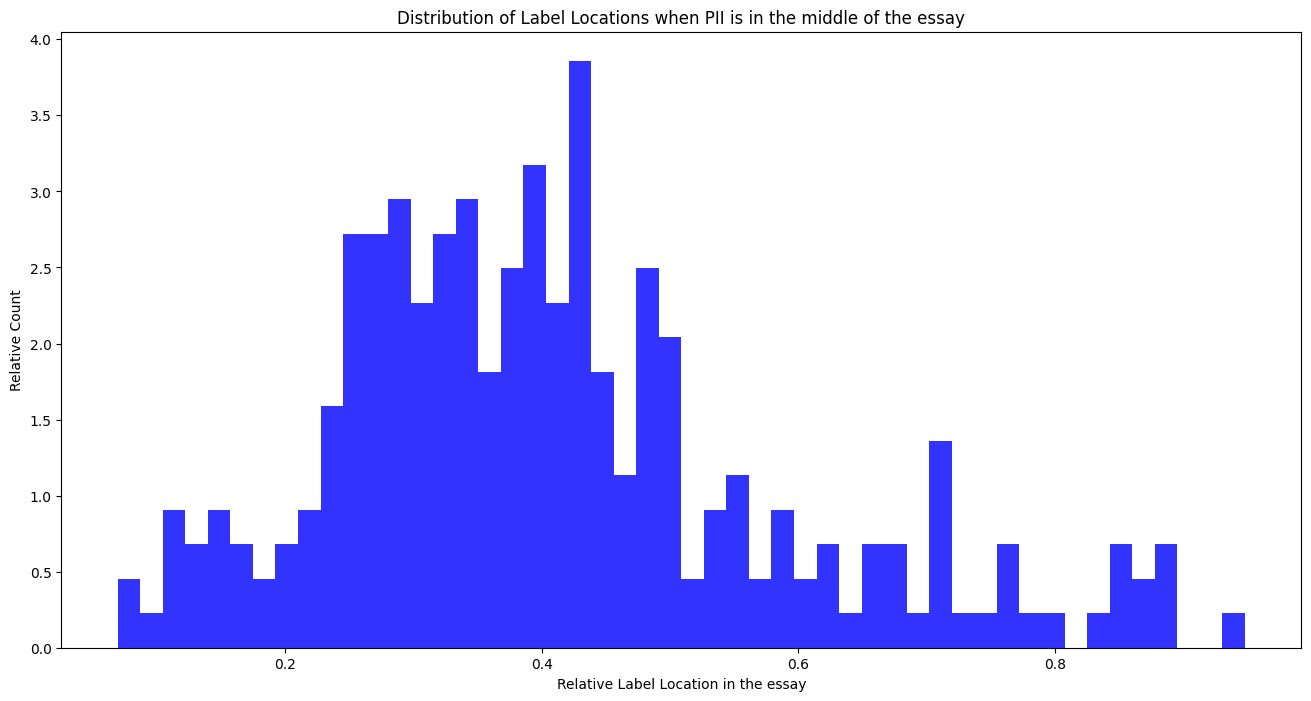

In [23]:
agg_label_location = df_pii_token_distro[df_pii_token_distro["document_class"] == 3][["document", "label_location"]].explode("label_location").dropna().groupby("document").agg("mean").reset_index()

# Make a histogram of the label locations
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.hist(agg_label_location["label_location"], bins=50, alpha=0.8, density=True, color='b')
plt.title("Distribution of Label Locations when PII is in the middle of the essay")
plt.xlabel("Relative Label Location in the essay")
plt.ylabel("Relative Count")
plt.show()


In [24]:
df_pii_token_distro["document_class"].value_counts()

document_class
0    5862
1     583
3     251
2     111
Name: count, dtype: int64

**Observe:** 5862 / 6807 documents (86%) have no PII tokens in the document at all! Of the remaining 945 documents, 583 (62%) have PII tokens only near the start and 111 (12%) have PII tokens only near the end. The remaining 251 (27%) have PII tokens spread throughout the document. The graph above shows a peak around 40% of the way through the document. This will be something to watch for during model training and evaluation - does location in the document play a role in classification accuracy?

In [25]:
df_class3_docs = df_pii_token_distro[df_pii_token_distro["document_class"] == 3].copy()
df_class3_docs.loc[:, 'html'] = df_class3_docs.apply(lambda x: highlight_entities(x['full_text'], x['tokens'], x['labels']), axis=1)

for html in df_class3_docs['html'].iloc[:5]:
    display(HTML(html))